Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

/home/feliciano/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Error cuadrático medio (MSE): 161469.73887471232
Raíz del error cuadrático medio (RMSE): 401.83297385196295
El precio predicho del Bitcoin para el día 2024-12-16 es: 102595.95


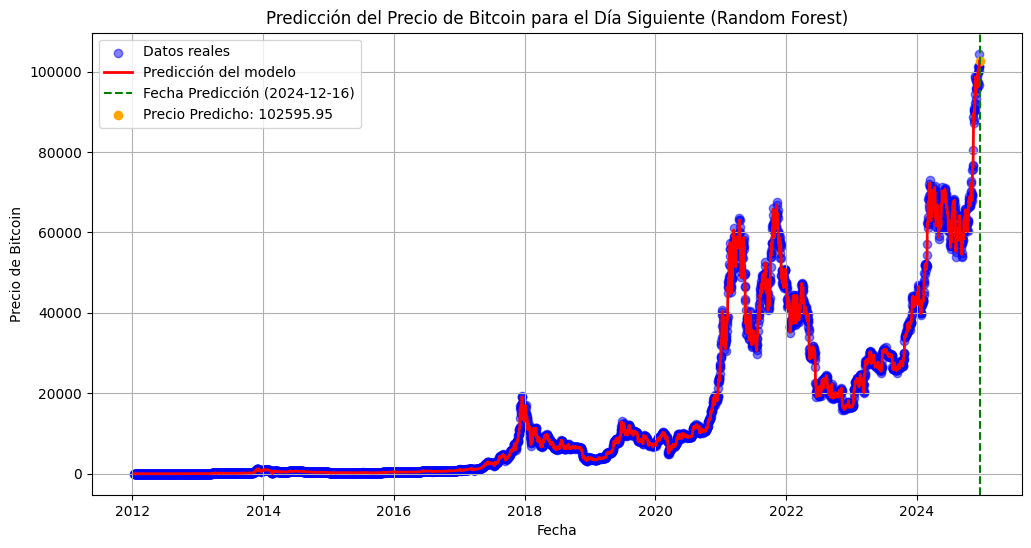

In [5]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit



# Cargar datos
df = pd.read_csv('bitcoin.csv', delimiter=',')

# Convertir fecha a formato datetime, manejar correctamente las comas
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')

# Verificar que las fechas estén ordenadas
df = df.sort_values(by='Fecha')

# Limpieza de columnas numéricas (se reemplazan las comas por puntos y eliminan los miles)
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpiar la columna de Volumen (convertir valores en 'K', 'M', 'B' a valores numéricos)
df['Vol.'] = (
    df['Vol.']
    .str.replace('K', '*1e3', regex=False)  # Miles
    .str.replace('M', '*1e6', regex=False)  # Millones
    .str.replace('B', '*1e9', regex=False)  # Miles de millones
    .str.replace('.', '', regex=False)  # Eliminar puntos
    .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
    .map(eval)  # Evaluar las expresiones matemáticas
)

# Crear las nuevas características
df['Rango'] = df['Máximo'] - df['Mínimo']
df['Cambio'] = df['Último'] - df['Apertura']

# Convertir fecha a número ordinal
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

# Crear las variables independientes (características)
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', 'Rango', 'Cambio']]

# La variable dependiente será el 'Último' (el precio final del día)
y = df['Último']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Crear el modelo Random Forest con hiperparámetros ajustados
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Número de árboles en el bosque
    'max_depth': [10, 15, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en una hoja
    'max_features': ['sqrt', 'log2']  # Número de características a considerar al buscar la mejor división
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=44), 
                           param_grid=param_grid, 
                           cv=tscv, n_jobs=-1, verbose=2)

# Ajustar el modelo con la búsqueda de cuadrícula
grid_search.fit(X_train, y_train)

# Entrenar el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred_rf = best_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

# Predicción para el siguiente día (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]],
    'Rango': [df['Rango'].iloc[-1]],
    'Cambio': [df['Cambio'].iloc[-1]]
})

precio_predicho_rf = best_model.predict(entrada_prediccion)[0]
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = best_model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
print("MSE promedio:", -scores.mean())

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Error absoluto medio (MAE): {mae_rf}")

MSE promedio: 15920546.511611566
Error absoluto medio (MAE): 160.58752642880216
